In [3]:
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix, vstack, hstack
from scipy import sparse

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from torch.optim import Adam

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names, build_input_features

from deepctr_torch.callbacks import EarlyStopping, ModelCheckpoint


In [5]:
import os

In [6]:
def sparse2tensor(sparse_mat):
    
    coo = sparse_mat.tocoo()

    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()


In [7]:
root = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook'

user_book = pd.read_feather(os.path.join(root, 'user_book_fea.ftr'), use_threads=True)
user_book = user_book[user_book.columns[1:]]
user_list = user_book.user.value_counts().index.to_numpy()
user_list = np.sort(user_list)

book_list = user_book.book.value_counts().index.to_numpy()
book_list = np.sort(book_list).astype(str)

n_users = user_list.shape[0]
n_books = book_list.shape[0]

In [9]:
data = user_book

In [10]:
def group_split(x):
    key_ans = x
    for key in key_ans:
        if key not in group_key2index:
            group_key2index[key] = len(group_key2index) + 1
    return list(map(lambda x: group_key2index[x], key_ans))

def user_inter_split(x):
    key_ans = x
    for key in key_ans:
        if key not in user_inter_key2index:
            user_inter_key2index[key] = len(user_inter_key2index) + 1
    return list(map(lambda x: user_inter_key2index[x], key_ans))

In [148]:
group_key2index = {}
group_list = list(map(group_split, data['group'].values))
group_length = np.array(list(map(len, group_list)))
group_max_len = max(group_length)
group_list = pad_sequences(group_list, maxlen=group_max_len, padding='post', )

In [149]:
user_inter_key2index = {}
user_inter_list = list(map(user_inter_split, data['user_inter'].values))
user_inter_length = np.array(list(map(len, user_inter_list)))
user_inter_max_len = max(user_inter_length)
user_inter_list = pad_sequences(user_inter_list, maxlen=user_inter_max_len, padding='post', )

In [150]:
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=50)
                          for feat in user_book.columns[3:7]]

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('group', vocabulary_size=len(
    group_key2index) + 1, embedding_dim=50), maxlen=group_max_len, combiner='mean'),
                          VarLenSparseFeat(SparseFeat('user_inter', vocabulary_size=len(
    user_inter_key2index) + 1, embedding_dim=50), maxlen=user_inter_max_len, combiner='mean')
                         ]  # Notice : value 0 is for padding for sequence input feature

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [151]:
model_input = {name: data[name] for name in user_book.columns[3:7]}  #
model_input["group"] = group_list
model_input["user_inter"] = user_inter_list

In [152]:
group_list =[]
user_inter_list = []

In [153]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

cuda ready...


In [154]:
feature_index = build_input_features(linear_feature_columns + dnn_feature_columns)
x = [model_input[feature] for feature in feature_index]
for i in range(len(x)):
    if len(x[i].shape) == 1:
        x[i] = np.expand_dims(x[i], axis=1)
sparse_x = [sparse.csr_matrix(fea) for fea in x]
sparse_x = hstack(sparse_x)
sparse_x = sparse_x.tocsr()
# sparse.save_npz('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/dctr_x.npz', sparse_x, True) 

In [18]:
# sparse_x = sparse.load_npz('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/dctr_x.npz').astype(np.int64)

In [156]:
target = data.rate.values

In [157]:

train_path = os.path.join(root, 'train')
val_path = os.path.join(root, 'val')
test_path = os.path.join(root, 'test')


In [158]:
from deepctr_torch.models import DeepFM
def DeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    
    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/deepfm/' + str(i) + '/deepfm_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])    
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/deepfm/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [159]:
from deepctr_torch.models.afm import AFM
def AFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = AFM(linear_feature_columns, dnn_feature_columns, afm_dropout=0.2, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/AFM/' + str(i) + '/AFM_{epoch}-{val_mse:.3f}.ckpt'

    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/AFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [160]:
from deepctr_torch.models.ccpm import CCPM
def CCPM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = CCPM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/CCPM/' + str(i) + '/CCPM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/CCPM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [161]:
from deepctr_torch.models.pnn import PNN
def IPNN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = PNN( dnn_feature_columns, dnn_dropout=0.2, use_inner=True, use_outter=False,  task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/IPNN/' + str(i) + '/IPNN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y  , batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/IPNN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [162]:
from deepctr_torch.models.pnn import PNN
def OPNN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = PNN( dnn_feature_columns, dnn_dropout=0.2,use_inner=False, use_outter=True,  task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/OPNN/' + str(i) + '/OPNN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y , batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/OPNN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [163]:
from deepctr_torch.models.wdl import WDL
def WDL_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = WDL(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/wide_deep/' + str(i) + '/wide_deep_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/wide_deep/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [164]:
from  deepctr_torch.models.nfm import NFM
def NFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = NFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.25, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/NFM/' + str(i) + '/NFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/NFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [165]:
from deepctr_torch.models.dcn import DCN
def DCN_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = DCN(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/DCN/' + str(i) + '/DCN_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/DCN/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [166]:
from deepctr_torch.models.xdeepfm import xDeepFM
def xDeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/xDeepFM/' + str(i) + '/xDeepFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/xDeepFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [167]:
from deepctr_torch.models.difm import DIFM
def DIFM_train(train_x_tensor, train_y, val_x_tensor, val_y):
    model = DIFM(linear_feature_columns, dnn_feature_columns, dnn_dropout=0.2, dnn_use_bn=True, task='regression', device=device)
    model.compile(Adam(model.parameters(),0.001), "mse", metrics=['mse'])
    s_p = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/DIFM/' + str(i) + '/DIFM_{epoch}-{val_mse:.3f}.ckpt'
    es = EarlyStopping(monitor='val_mse', min_delta=0, verbose=1, patience=5, mode='min')
    mdckpt = ModelCheckpoint(filepath = s_p,monitor="val_mse",mode="min",  save_best_only= True)
    history = model.fit(train_x=train_x_tensor, train_y=train_y, val_x=val_x_tensor, val_y=val_y, batch_size=256, epochs=50, verbose=2,callbacks=[es,mdckpt])
    train_mse = history.history['mse']
    val_mse = history.history['val_mse']
    values = np.arange(1, len(history.history['mse'])+1)

    with plt.style.context('fivethirtyeight'):

        plt.plot(values, train_mse, label='train_mse', linestyle='--')
        plt.plot(values, val_mse, label='val_mse', ls='--')
    plt.legend()
    plt.savefig('C:/Users/bbb50/Desktop/Python/hw3/DoubanBook/model/DIFM/' + str(i) +'/mse.png')
    plt.show()
    fig = plt.gcf() 

    plt.close(fig) 

In [36]:
i = 0
train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

train_x = sparse_x[train_ind]
val_x = sparse_x[val_ind]
test_x = sparse_x[test_ind]

train_y=target[train_ind]
val_y=target[val_ind]
test_y=target[test_ind]

train_x_tensor = sparse2tensor(train_x)
val_x_tensor = sparse2tensor(val_x)
test_x_tensor = sparse2tensor(test_x)

In [99]:
from matplotlib import pyplot as plt

number: 0
DeepFM
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
54s - loss:  0.7830 - mse:  0.7830 - val_mse:  0.5293
Epoch 2/50
54s - loss:  0.5016 - mse:  0.5016 - val_mse:  0.5055
Epoch 3/50
53s - loss:  0.4772 - mse:  0.4770 - val_mse:  0.4973
Epoch 4/50
53s - loss:  0.4523 - mse:  0.4520 - val_mse:  0.4961
Epoch 5/50
53s - loss:  0.4241 - mse:  0.4237 - val_mse:  0.4957
Epoch 6/50
54s - loss:  0.3944 - mse:  0.3939 - val_mse:  0.5048
Epoch 7/50
55s - loss:  0.3648 - mse:  0.3641 - val_mse:  0.5084
Epoch 8/50
55s - loss:  0.3372 - mse:  0.3364 - val_mse:  0.5241
Epoch 9/50
58s - loss:  0.3132 - mse:  0.3121 - val_mse:  0.5276
Epoch 10/50
54s - loss:  0.2919 - mse:  0.2907 - val_mse:  0.5378
Epoch 00010: early stopping


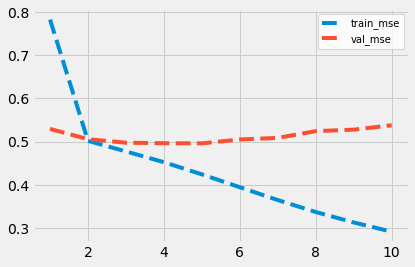

AFM
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
52s - loss:  1.7021 - mse:  1.7009 - val_mse:  0.5634
Epoch 2/50
53s - loss:  0.5318 - mse:  0.5303 - val_mse:  0.5217
Epoch 3/50
52s - loss:  0.5014 - mse:  0.4996 - val_mse:  0.5098
Epoch 4/50
52s - loss:  0.4889 - mse:  0.4869 - val_mse:  0.5036
Epoch 5/50
53s - loss:  0.4798 - mse:  0.4776 - val_mse:  0.5020
Epoch 6/50
52s - loss:  0.4715 - mse:  0.4692 - val_mse:  0.4996
Epoch 7/50
53s - loss:  0.4631 - mse:  0.4607 - val_mse:  0.4959
Epoch 8/50
53s - loss:  0.4541 - mse:  0.4515 - val_mse:  0.4963
Epoch 9/50
53s - loss:  0.4440 - mse:  0.4413 - val_mse:  0.4960
Epoch 10/50
56s - loss:  0.4325 - mse:  0.4297 - val_mse:  0.4974
Epoch 11/50
56s - loss:  0.4202 - mse:  0.4173 - val_mse:  0.4971
Epoch 12/50
54s - loss:  0.4070 - mse:  0.4040 - val_mse:  0.5002
Epoch 00012: early stopping


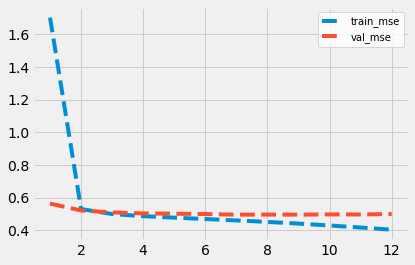

CCPM
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
62s - loss:  0.7744 - mse:  0.7743 - val_mse:  0.7916
Epoch 2/50
63s - loss:  0.9682 - mse:  0.9681 - val_mse:  0.5807
Epoch 3/50
62s - loss:  0.5517 - mse:  0.5515 - val_mse:  0.5436
Epoch 4/50
62s - loss:  0.5250 - mse:  0.5248 - val_mse:  0.5295
Epoch 5/50
62s - loss:  0.5118 - mse:  0.5116 - val_mse:  0.5223
Epoch 6/50
63s - loss:  0.5039 - mse:  0.5037 - val_mse:  0.5183
Epoch 7/50
63s - loss:  0.4987 - mse:  0.4984 - val_mse:  0.5154
Epoch 8/50
63s - loss:  0.4947 - mse:  0.4944 - val_mse:  0.5137
Epoch 9/50
62s - loss:  0.4919 - mse:  0.4915 - val_mse:  0.5124
Epoch 10/50
62s - loss:  0.4896 - mse:  0.4892 - val_mse:  0.5113
Epoch 11/50
62s - loss:  0.4878 - mse:  0.4874 - val_mse:  0.5104
Epoch 12/50
62s - loss:  0.4863 - mse:  0.4858 - val_mse:  0.5094
Epoch 13/50
62s - loss:  0.4850 - mse:  0.4845 - val_mse:  0.5092
Epoch 14/50
62s - loss:  0.4840 - mse:  0.4835 - val_mse:  0.5086


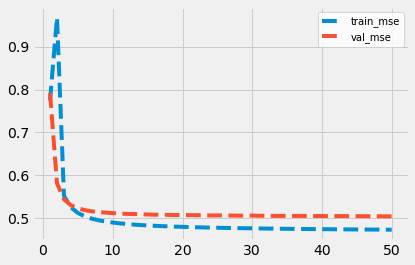

IPNN
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
39s - loss:  0.9022 - mse:  0.9021 - val_mse:  0.5235
Epoch 2/50
39s - loss:  0.5064 - mse:  0.5062 - val_mse:  0.5077
Epoch 3/50
39s - loss:  0.4876 - mse:  0.4872 - val_mse:  0.5006
Epoch 4/50
39s - loss:  0.4656 - mse:  0.4651 - val_mse:  0.4939
Epoch 5/50
38s - loss:  0.4303 - mse:  0.4297 - val_mse:  0.4933
Epoch 6/50
39s - loss:  0.3791 - mse:  0.3783 - val_mse:  0.5122
Epoch 7/50
38s - loss:  0.3208 - mse:  0.3199 - val_mse:  0.5292
Epoch 8/50
38s - loss:  0.2691 - mse:  0.2680 - val_mse:  0.5554
Epoch 9/50
39s - loss:  0.2325 - mse:  0.2312 - val_mse:  0.5709
Epoch 10/50
38s - loss:  0.2058 - mse:  0.2045 - val_mse:  0.5814
Epoch 00010: early stopping


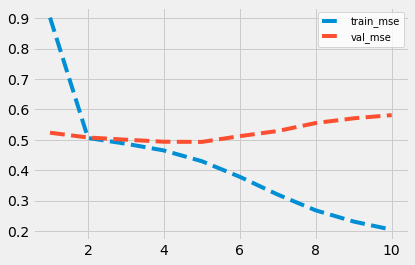

OPNN
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
42s - loss:  0.9321 - mse:  0.9320 - val_mse:  0.5249
Epoch 2/50
41s - loss:  0.5113 - mse:  0.5111 - val_mse:  0.5133
Epoch 3/50
41s - loss:  0.4973 - mse:  0.4970 - val_mse:  0.5184
Epoch 4/50
41s - loss:  0.4853 - mse:  0.4848 - val_mse:  0.5010
Epoch 5/50
41s - loss:  0.4736 - mse:  0.4730 - val_mse:  0.5014
Epoch 6/50
41s - loss:  0.4619 - mse:  0.4611 - val_mse:  0.5077
Epoch 7/50
41s - loss:  0.4470 - mse:  0.4461 - val_mse:  0.5036
Epoch 8/50
41s - loss:  0.4297 - mse:  0.4286 - val_mse:  0.5017
Epoch 9/50
41s - loss:  0.4108 - mse:  0.4095 - val_mse:  0.5114
Epoch 00009: early stopping


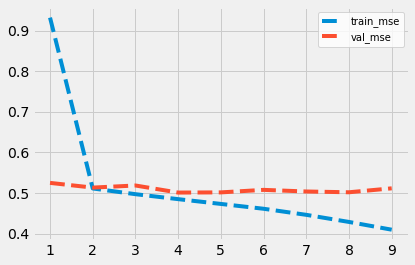

WDL
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
54s - loss:  0.8345 - mse:  0.8344 - val_mse:  0.5285
Epoch 2/50
54s - loss:  0.5124 - mse:  0.5123 - val_mse:  0.5168
Epoch 3/50
54s - loss:  0.5045 - mse:  0.5042 - val_mse:  0.5190
Epoch 4/50
53s - loss:  0.4993 - mse:  0.4988 - val_mse:  0.5092
Epoch 5/50
53s - loss:  0.4962 - mse:  0.4957 - val_mse:  0.5185
Epoch 6/50
52s - loss:  0.4941 - mse:  0.4934 - val_mse:  0.5208
Epoch 7/50
52s - loss:  0.4913 - mse:  0.4905 - val_mse:  0.5083
Epoch 8/50
52s - loss:  0.4877 - mse:  0.4867 - val_mse:  0.5045
Epoch 9/50
53s - loss:  0.4805 - mse:  0.4793 - val_mse:  0.5038
Epoch 10/50
53s - loss:  0.4733 - mse:  0.4720 - val_mse:  0.4970
Epoch 11/50
53s - loss:  0.4657 - mse:  0.4643 - val_mse:  0.4998
Epoch 12/50
53s - loss:  0.4585 - mse:  0.4570 - val_mse:  0.5022
Epoch 13/50
53s - loss:  0.4510 - mse:  0.4494 - val_mse:  0.4974
Epoch 14/50
52s - loss:  0.4434 - mse:  0.4417 - val_mse:  0.4991
E

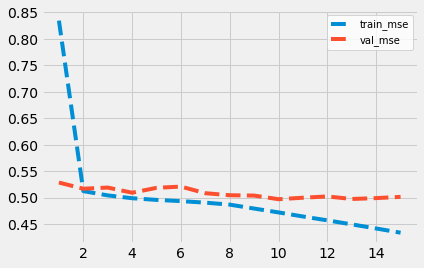

NFM
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
53s - loss:  0.9296 - mse:  0.9295 - val_mse:  0.5152
Epoch 2/50
52s - loss:  0.4813 - mse:  0.4811 - val_mse:  0.4982
Epoch 3/50
54s - loss:  0.4449 - mse:  0.4445 - val_mse:  0.4966
Epoch 4/50
53s - loss:  0.4165 - mse:  0.4160 - val_mse:  0.5006
Epoch 5/50
54s - loss:  0.3928 - mse:  0.3921 - val_mse:  0.5088
Epoch 6/50
68s - loss:  0.3693 - mse:  0.3685 - val_mse:  0.5118
Epoch 7/50
76s - loss:  0.3447 - mse:  0.3438 - val_mse:  0.5263
Epoch 8/50
62s - loss:  0.3184 - mse:  0.3173 - val_mse:  0.5382
Epoch 00008: early stopping


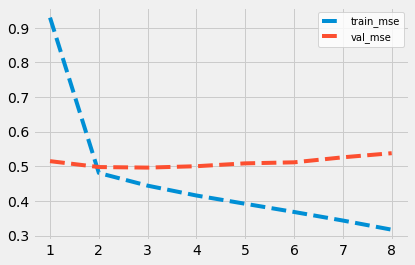

DCN
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
59s - loss:  0.6628 - mse:  0.6628 - val_mse:  0.5153
Epoch 2/50
63s - loss:  0.4972 - mse:  0.4971 - val_mse:  0.5033
Epoch 3/50
57s - loss:  0.4751 - mse:  0.4749 - val_mse:  0.4971
Epoch 4/50
54s - loss:  0.4534 - mse:  0.4531 - val_mse:  0.4997
Epoch 5/50
54s - loss:  0.4310 - mse:  0.4306 - val_mse:  0.4977
Epoch 6/50
56s - loss:  0.4086 - mse:  0.4080 - val_mse:  0.4983
Epoch 7/50
54s - loss:  0.3872 - mse:  0.3864 - val_mse:  0.5127
Epoch 8/50
56s - loss:  0.3668 - mse:  0.3660 - val_mse:  0.5102
Epoch 00008: early stopping


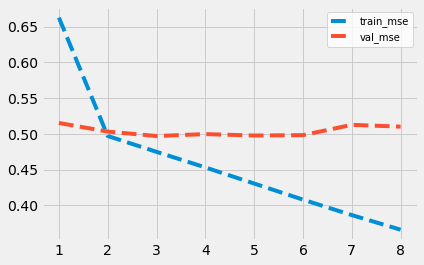

xDeepFM
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
66s - loss:  0.5995 - mse:  0.5994 - val_mse:  0.5254
Epoch 2/50
68s - loss:  0.4979 - mse:  0.4978 - val_mse:  0.5013
Epoch 3/50
66s - loss:  0.4721 - mse:  0.4719 - val_mse:  0.4942
Epoch 4/50
66s - loss:  0.4436 - mse:  0.4433 - val_mse:  0.4882
Epoch 5/50
66s - loss:  0.4009 - mse:  0.4004 - val_mse:  0.4992
Epoch 6/50
67s - loss:  0.3419 - mse:  0.3412 - val_mse:  0.5163
Epoch 7/50
66s - loss:  0.2868 - mse:  0.2860 - val_mse:  0.5387
Epoch 8/50
66s - loss:  0.2465 - mse:  0.2456 - val_mse:  0.5661
Epoch 9/50
66s - loss:  0.2182 - mse:  0.2172 - val_mse:  0.5834
Epoch 00009: early stopping


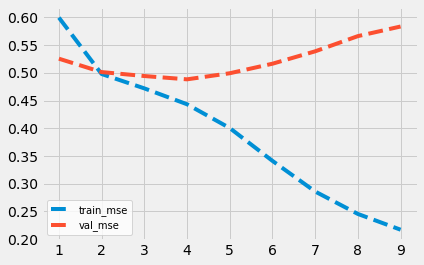

DIFM
cuda:0
Train on 553137 samples, validate on 79020 samples, 2161 steps per epoch
Epoch 1/50
58s - loss:  0.8789 - mse:  0.8789 - val_mse:  0.5263
Epoch 2/50
56s - loss:  0.5055 - mse:  0.5054 - val_mse:  0.5075
Epoch 3/50
56s - loss:  0.4644 - mse:  0.4642 - val_mse:  0.4955
Epoch 4/50
56s - loss:  0.4059 - mse:  0.4056 - val_mse:  0.5064
Epoch 5/50
56s - loss:  0.3365 - mse:  0.3360 - val_mse:  0.5314
Epoch 6/50
56s - loss:  0.2849 - mse:  0.2843 - val_mse:  0.5331
Epoch 7/50
57s - loss:  0.2496 - mse:  0.2489 - val_mse:  0.5548
Epoch 8/50
56s - loss:  0.2257 - mse:  0.2248 - val_mse:  0.5620
Epoch 00008: early stopping


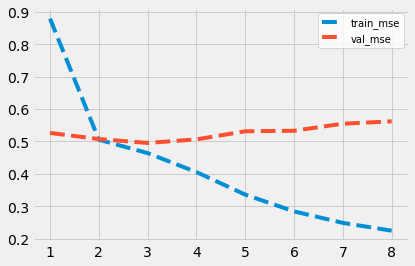

In [168]:
for i in range(1):
    train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
    val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))
    
    train_x = sparse_x[train_ind]
    val_x = sparse_x[val_ind]
    test_x = sparse_x[test_ind]

    train_y=target[train_ind]
    val_y=target[val_ind]
    test_y=target[test_ind]
    
    train_x_tensor = sparse2tensor(train_x)
    val_x_tensor = sparse2tensor(val_x)
    test_x_tensor = sparse2tensor(test_x)
    
    print('==================================================')
    print('number:', i)
    print('DeepFM')
    DeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('AFM')
    AFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('CCPM')
    CCPM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('IPNN')
    IPNN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('OPNN')
    OPNN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('WDL')
    WDL_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('NFM')
    NFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('DCN')
    DCN_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('xDeepFM')
    xDeepFM_train(train_x_tensor, train_y, val_x_tensor, val_y)
    print('DIFM')
    DIFM_train(train_x_tensor, train_y, val_x_tensor, val_y)

In [22]:
m = torch.load('test.ckpt')

In [33]:
m.predict(test_x_tensor)

array([[4.00951767],
       [3.93800592],
       [4.28843737],
       ...,
       [4.74223948],
       [3.6681757 ],
       [3.4003098 ]])